6-1. 프로젝트 : 폐렴 진단기 성능개선
---

앞서 폐렴 진단기를 만들었다. 

그 진단기 성능보다 더 좋은 성능의 프로그램을 만들어 보려고 한다. 

나는 코랩 환경에서 만들 예정이기에 아래와 같이 데이터를 내 구글 드라이브에 올린후 불러와서 시작했다. 

그 이후 파일이 안올라가져서 아이펠 클라우드에서 진행했다.

In [4]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [6]:
# 'tf.io.gfile.glob' 함수 이용해서 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)

test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
# 데이터를 train:val = 80:20 으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))
# 나누게 되면 train은 4185개, test는 624개, val은 1047개

4185
1047


In [8]:
# 정상 이미지, 폐렴 이미지로 구분 
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")
# 결과에 정상보다 폐렴 이미지수가 3배 더 있다는 것을 확인해야함.

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 한다. 

미니배치는 오버피팅이 나지 않을 수 있도록 도와준다. 

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# train, val 데이터셋의 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
# 이미지에 라벨링이 되어있지 않기 때문에 파일 경로에 포함되어있는 'NORMAL', 'PNEUMONIA'를 이용해 라벨 데이터를 만들어주는 함수 사용
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터의 사이즈를 통일 시키고, GPU 메모리를 효율을 위해 이미지 사이즈 줄임.

decode_img 함수와 process_path 함수 이용

이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경, get_label을 이용해서 라벨 값을 가져온다. 

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
# train 데이터 셋과 validation 데이터셋 생성, num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용해서 빠르게 처리
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# 이미지 리사이즈와 라벨링 확인 
# train_ds.take(1)은 하나의 데이터만 가져온다는 의미
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
# train과 validation 데이터셋을 만든 것처럼 test 데이터셋 생성, 데이터 개수 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
# 데이터 증강
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

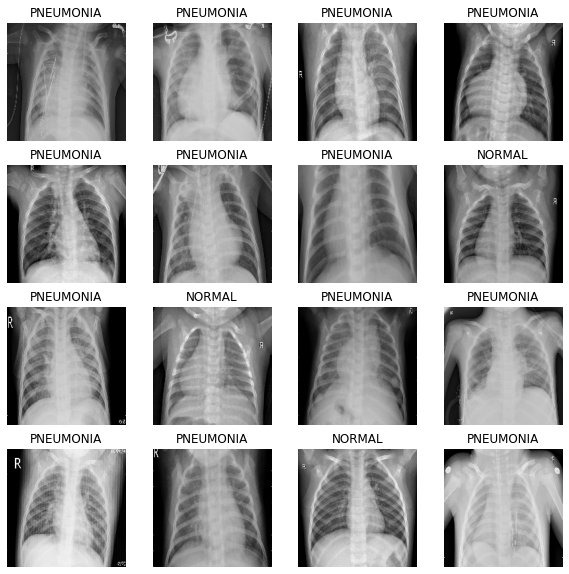

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        # 이미지 차원 확인 및 조정
        img = image_batch[n].numpy()
        plt.imshow(img)
        title = "PNEUMONIA" if label_batch[n] else "NORMAL"
        plt.title(title)
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

In [19]:
# 클래스 별 이미지 수를 계산
label_batch_np = tf.cast(label_batch, tf.int32).numpy()

COUNT_NORMAL = len([label for label in label_batch_np if label == 0])
COUNT_PNEUMONIA = len([label for label in label_batch_np if label == 1])

print('Number of normal images in the batch:', COUNT_NORMAL)
print('Number of pneumonia images in the batch:', COUNT_PNEUMONIA)

Number of normal images in the batch: 3
Number of pneumonia images in the batch: 13


# Step 4. ResNet-18 구현
---

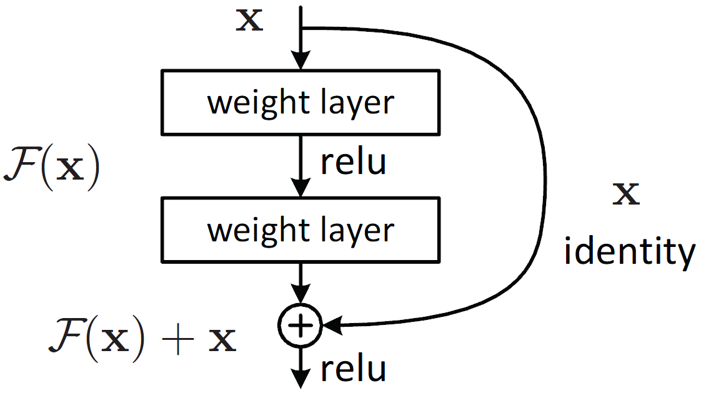

---


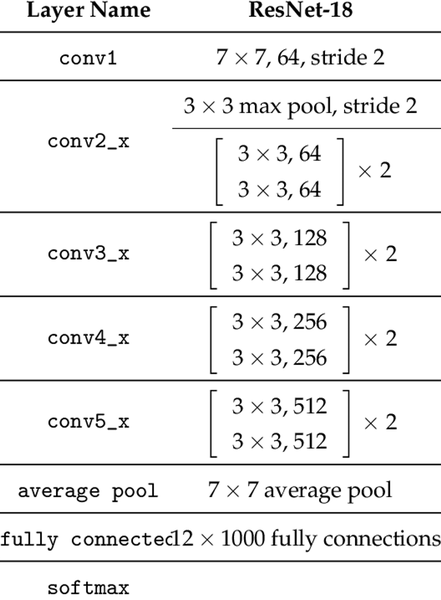

In [20]:
# ResNet 구현을 위한 Residual block을 먼저 구성
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense

def residual_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False):
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [21]:
# ResNet 구현
def ResNet18(input_shape=(180, 180, 3), classes=1):  
    inputs = Input(shape=input_shape)

    # Initial Convolution and MaxPooling layer
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # First set of residual blocks
    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64)

    # Second set of residual blocks
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)

    # Third set of residual blocks
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)

    # Fourth set of residual blocks
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)

    # Average Pooling and Fully Connected layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=x)
    return model

# Instantiate the model
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 90, 90, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
# 여기서 COUNT_NORMAL과 COUNT_PNEUMONIA는 데이터셋에서 각 클래스의 이미지 수
COUNT_NORMAL = len([label for label in label_batch_np if label == 0])
COUNT_PNEUMONIA = len([label for label in label_batch_np if label == 1])
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 2.67
Weight for PNEUMONIA: 0.62


# 모델 훈련

In [23]:
with tf.device('/GPU:0'):
    model = ResNet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
# 모델 fit 각 파라미터에 위에서 선언했던 변수, 데이터셋을 가져와 맞춰서 넣어줌.
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
1/1 [==============================] - 30s 30s/step - loss: 0.8406 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6285 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 16s 16s/step - loss: 1.0176 - accuracy: 0.5625 - precision: 0.8333 - recall: 0.4545 - val_loss: 0.7328 - val_accuracy: 0.3394 - val_precision: 0.9872 - val_recall: 0.1009
Epoch 3/10
1/1 [==============================] - 16s 16s/step - loss: 2.8128 - accuracy: 0.4375 - precision: 0.7778 - recall: 0.5000 - val_loss: 0.6069 - val_accuracy: 0.7231 - val_precision: 0.7301 - val_recall: 0.9869
Epoch 4/10
1/1 [==============================] - 16s 16s/step - loss: 5.8350 - accuracy: 0.3750 - precision: 0.7500 - recall: 0.4286 - val_loss: 0.6836 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 5/10
1/1 [==============================] - 16s 16s/step - loss: 4.5258 - accuracy: 0.4375 - p

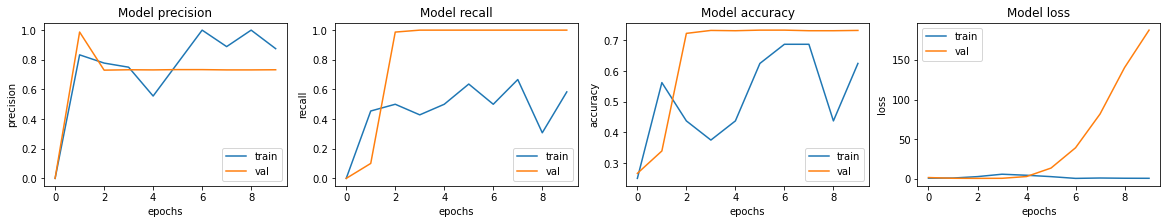

In [25]:
# 결과 확인 => 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

In [26]:
# 테스트 데이터로 모델 평가 
# loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 126ms/step - loss: 264.3374 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 264.3373718261719,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 회고
---
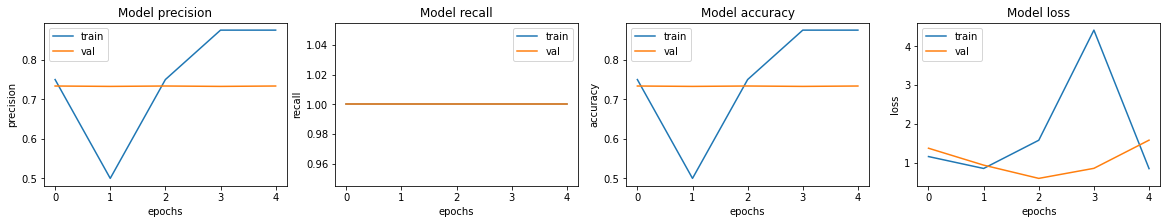
첫번째 모델을 돌렸을 때 심각하게 어큐러시도 낮고 안좋아서 왜일까 고민을 하다가 
배치사이즈 조정과 에폭수를 조정했다. 
그랬더니 좀 나아지긴했지만 여전히 val_loss 와 val_accuracy가 심각해서 ResNet 모델을 차근차근 살펴보니 여러개 시도했던 것중에 softmax로 빼고 있었던 것을 확인하고 sigmoid(이중분류)로 바꾸러 주었더니 조금 나아졌다. 



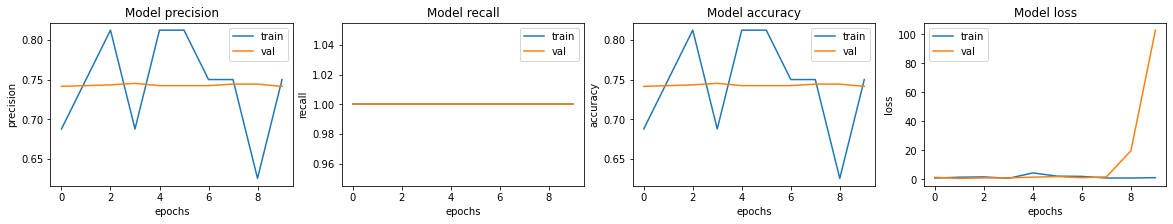

---


Keep: 여러가지 시도를 해보는 것
---

Problem: 언제쯤 나의 Accuracy 는 높아지려나... 하핳
---

Try: 다음에는 좀 더 여러가지를 진행해봐야지
---